In [1]:
import torch
from torch import nn

In [2]:
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.transforms import ToTensor

train_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

class_names = train_data.classes

100%|██████████| 26421880/26421880 [00:01<00:00, 15752189.85it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271717.76it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4976384.02it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11124305.51it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
import matplotlib.pyplot as plt

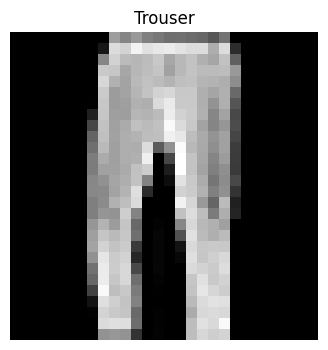

In [4]:
plt.figure(figsize=(5, 4))

random_idx = torch.randint(0, len(train_data), size=[1]).item()
img, label = train_data[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [6]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, out_shape=10, hidden_units=6, activation_fn=nn.Sigmoid):
        super().__init__()
        self.activation_fn = activation_fn 
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=5, stride=1, padding=2),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=hidden_units, out_channels=(hidden_units + 10), kernel_size=5, stride=1, padding=0),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=120), activation_fn(),
            nn.Linear(120, 84), activation_fn(),
            nn.Linear(84, out_shape),
        )
        dummy_input = torch.randn(1, 1, 28, 28) 
        _ = self(dummy_input)
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)  
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0) 

    def forward(self, x):
        x = self.block_1(x)
        x = self.classifier(x)

        return x

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
def train_step(model, train_dataloader, loss_fn, accuracy_fn, optimizer, device="cpu"):
    model.to(device)
    model.train()
    train_loss = train_acc = 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        y_logits = model(X)

        loss = loss_fn(y_logits, y)

        train_loss += loss
        train_acc += accuracy_fn(y_logits.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    return train_loss.detach().cpu().item(), train_acc


def test_step(model, train_dataloader, loss_fn, accuracy_fn, device="cpu"):
    model.to(device)
    model.eval()
    test_loss = test_acc = 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_logits = model(X)
        
            test_loss += loss_fn(y_logits, y)
            test_acc += accuracy_fn(y_logits.argmax(dim=1), y)
    
    
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
        return test_loss.detach().cpu().item(), test_acc

In [9]:
def accuracy_fn(y_pred, y_true):
    return torch.eq(y_pred, y_true).sum().item() / len(y_true)

# Sigmoid as activation func

In [10]:
model_0 = LeNet(out_shape=len(class_names), activation_fn=nn.Sigmoid)

In [11]:
from tqdm.auto import tqdm

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_0.parameters(), lr=0.01, momentum=0.9, nesterov=True)

epoches = 11

train_losses_0 = []
test_losses_0 = []
test_acc_0 = []

for epoche in tqdm(range(epoches)):
    train_info = train_step(model_0, train_dataloader, loss_fn, accuracy_fn, optim, device)
    test_info = test_step(model_0, test_dataloader, loss_fn, accuracy_fn, device)

    if epoche % 2 == 0:
        print(f"Epoche: {epoche}\n---------")
        print(f"Train loss: {train_info[0]:.5f} | Train accuracy: {train_info[1]:.2f}%")
        print(f"Test loss: {test_info[0]:.5f} | Test accuracy: {test_info[1]:.2f}%")

    train_losses_0.append(train_info[0])
    test_losses_0.append(test_info[0])
    test_acc_0.append(test_info[1])

  0%|          | 0/11 [00:00<?, ?it/s]

Epoche: 0
---------
Train loss: 2.31171 | Train accuracy: 0.10%
Test loss: 2.30589 | Test accuracy: 0.10%
Epoche: 2
---------
Train loss: 2.29661 | Train accuracy: 0.12%
Test loss: 2.28267 | Test accuracy: 0.20%
Epoche: 4
---------
Train loss: 1.17769 | Train accuracy: 0.57%
Test loss: 1.04956 | Test accuracy: 0.62%
Epoche: 6
---------
Train loss: 0.85724 | Train accuracy: 0.69%
Test loss: 0.82259 | Test accuracy: 0.70%
Epoche: 8
---------
Train loss: 0.69374 | Train accuracy: 0.74%
Test loss: 0.68485 | Test accuracy: 0.74%
Epoche: 10
---------
Train loss: 0.61649 | Train accuracy: 0.76%
Test loss: 0.62923 | Test accuracy: 0.76%


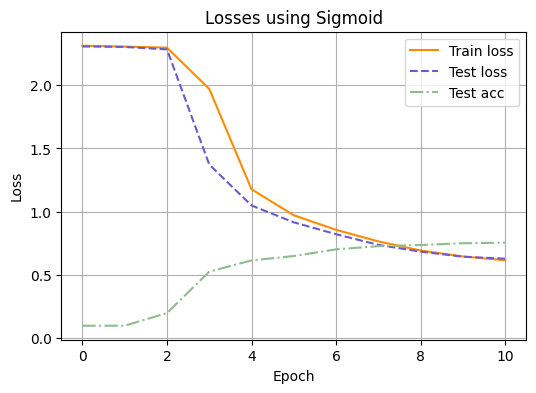

In [12]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), train_losses_0, c="darkorange",label="Train loss")
plt.plot(range(epoches), test_losses_0, c="slateblue", ls='dashed', label="Test loss")
plt.plot(range(epoches), test_acc_0, c="darkseagreen", ls='dashdot', label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses using Sigmoid")
plt.legend()
plt.grid(True)
plt.show()

# ReLU as activation func

In [13]:
model_1 = LeNet(out_shape=len(class_names), activation_fn=nn.ReLU)

from tqdm.auto import tqdm

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9, nesterov=True)

epoches = 11

train_losses_1 = []
test_losses_1 = []
test_acc_1 = []

for epoche in tqdm(range(epoches)):
    train_info = train_step(model_1, train_dataloader, loss_fn, accuracy_fn, optim, device)
    test_info = test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)

    if epoche % 2 == 0:
        print(f"Epoche: {epoche}\n---------")
        print(f"Train loss: {train_info[0]:.5f} | Train accuracy: {train_info[1]:.2f}%")
        print(f"Test loss: {test_info[0]:.5f} | Test accuracy: {test_info[1]:.2f}%")

    train_losses_1.append(train_info[0])
    test_losses_1.append(test_info[0])
    test_acc_1.append(test_info[1])

  0%|          | 0/11 [00:00<?, ?it/s]

Epoche: 0
---------
Train loss: 0.75281 | Train accuracy: 0.72%
Test loss: 0.50445 | Test accuracy: 0.81%
Epoche: 2
---------
Train loss: 0.36959 | Train accuracy: 0.87%
Test loss: 0.38141 | Test accuracy: 0.87%
Epoche: 4
---------
Train loss: 0.31543 | Train accuracy: 0.89%
Test loss: 0.34542 | Test accuracy: 0.87%
Epoche: 6
---------
Train loss: 0.28548 | Train accuracy: 0.89%
Test loss: 0.34045 | Test accuracy: 0.88%
Epoche: 8
---------
Train loss: 0.26650 | Train accuracy: 0.90%
Test loss: 0.31408 | Test accuracy: 0.89%
Epoche: 10
---------
Train loss: 0.24734 | Train accuracy: 0.91%
Test loss: 0.29486 | Test accuracy: 0.90%


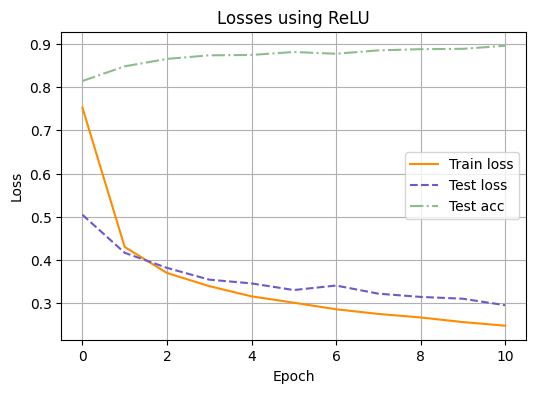

In [14]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), train_losses_1, c="darkorange",label="Train loss")
plt.plot(range(epoches), test_losses_1, c="slateblue", ls='dashed', label="Test loss")
plt.plot(range(epoches), test_acc_1, c="darkseagreen", ls='dashdot', label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses using ReLU")
plt.legend()
plt.grid(True)
plt.show()

# GELU as activation func

In [15]:
model_2 = LeNet(out_shape=len(class_names), activation_fn=nn.GELU)

from tqdm.auto import tqdm

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9, nesterov=True)

epoches = 11

train_losses_2 = []
test_losses_2 = []
test_acc_2 = []

for epoche in tqdm(range(epoches)):
    train_info = train_step(model_2, train_dataloader, loss_fn, accuracy_fn, optim, device)
    test_info = test_step(model_2, test_dataloader, loss_fn, accuracy_fn, device)

    if epoche % 2 == 0:
        print(f"Epoche: {epoche}\n---------")
        print(f"Train loss: {train_info[0]:.5f} | Train accuracy: {train_info[1]:.2f}%")
        print(f"Test loss: {test_info[0]:.5f} | Test accuracy: {test_info[1]:.2f}%")

    train_losses_2.append(train_info[0])
    test_losses_2.append(test_info[0])
    test_acc_2.append(test_info[1])

  0%|          | 0/11 [00:00<?, ?it/s]

Epoche: 0
---------
Train loss: 0.80294 | Train accuracy: 0.71%
Test loss: 0.47061 | Test accuracy: 0.83%
Epoche: 2
---------
Train loss: 0.34858 | Train accuracy: 0.87%
Test loss: 0.35613 | Test accuracy: 0.87%
Epoche: 4
---------
Train loss: 0.29567 | Train accuracy: 0.89%
Test loss: 0.32733 | Test accuracy: 0.88%
Epoche: 6
---------
Train loss: 0.26542 | Train accuracy: 0.90%
Test loss: 0.31101 | Test accuracy: 0.89%
Epoche: 8
---------
Train loss: 0.24450 | Train accuracy: 0.91%
Test loss: 0.31013 | Test accuracy: 0.89%
Epoche: 10
---------
Train loss: 0.22785 | Train accuracy: 0.91%
Test loss: 0.29079 | Test accuracy: 0.89%


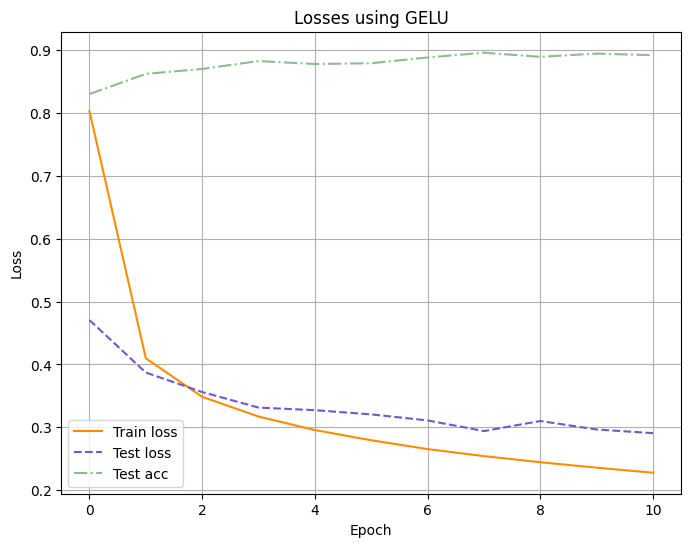

In [16]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoches), train_losses_2, c="darkorange",label="Train loss")
plt.plot(range(epoches), test_losses_2, c="slateblue", ls='dashed', label="Test loss")
plt.plot(range(epoches), test_acc_2, c="darkseagreen", ls='dashdot', label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses using GELU")
plt.legend()
plt.grid(True)
plt.show()

# Comparsion

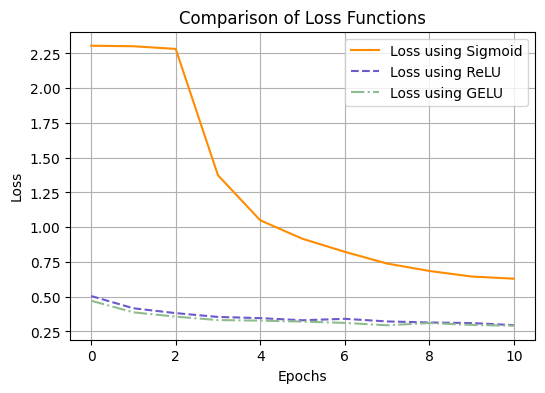

In [17]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), test_losses_0, c="darkorange", label="Loss using Sigmoid")
plt.plot(range(epoches), test_losses_1, c="slateblue", ls='dashed', label="Loss using ReLU")
plt.plot(range(epoches), test_losses_2, c="darkseagreen", ls='dashdot', label="Loss using GELU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of Loss Functions")
plt.legend()
plt.grid(True)
plt.show()


# Activation map Visualization


In [18]:
activations = {}

layer_types = {}

def hook_fn(name, layer_type):
    def hook(module, input, output):
        activations[name] = output
        layer_types[name] = layer_type
    return hook

for name, module in model_2.named_modules():
    layer_type = type(module).__name__
    module.register_forward_hook(hook_fn(name, layer_type))

In [19]:
random_idx = torch.randint(0, len(test_data), size=[1]).item()
img, label = test_data[random_idx]
class_names[label]

'Sneaker'

In [20]:
out = model_2.cpu()(img.unsqueeze(dim=0))

Visualizing: Conv2d, shape: torch.Size([1, 6, 28, 28])


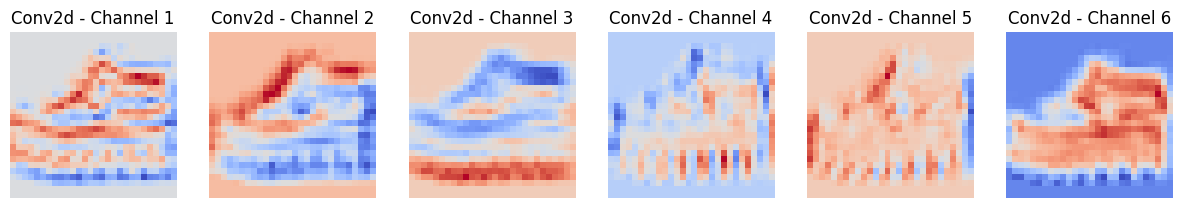

Visualizing: GELU, shape: torch.Size([1, 6, 28, 28])


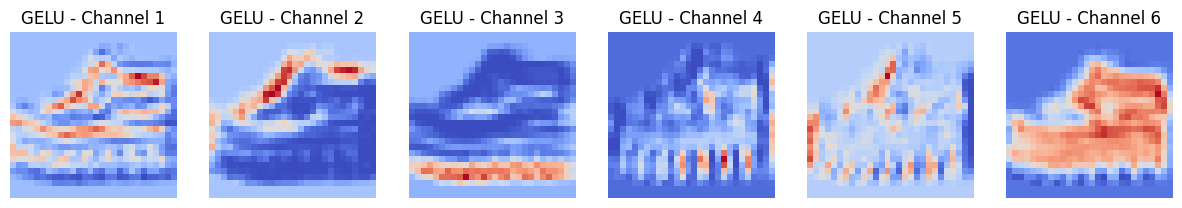

Visualizing: MaxPool2d, shape: torch.Size([1, 6, 14, 14])


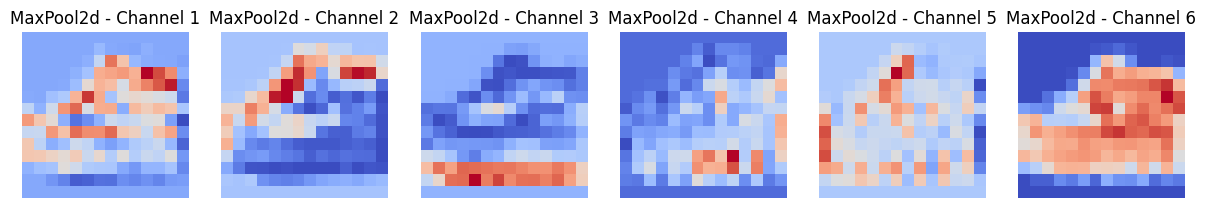

Visualizing: Conv2d, shape: torch.Size([1, 16, 10, 10])


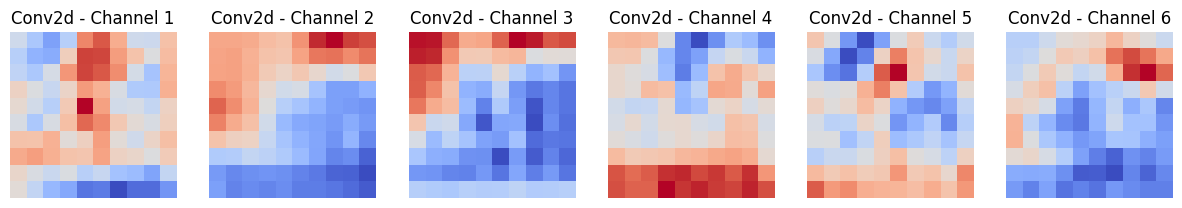

Visualizing: GELU, shape: torch.Size([1, 16, 10, 10])


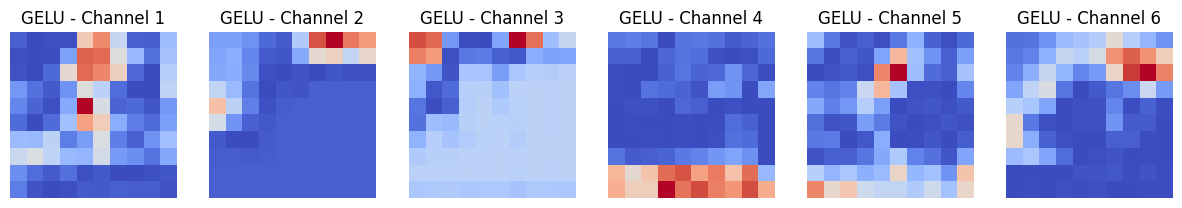

Visualizing: MaxPool2d, shape: torch.Size([1, 16, 5, 5])


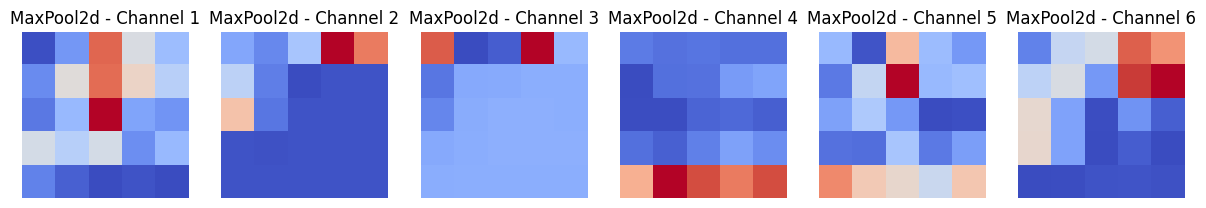

Visualizing: Sequential, shape: torch.Size([1, 16, 5, 5])


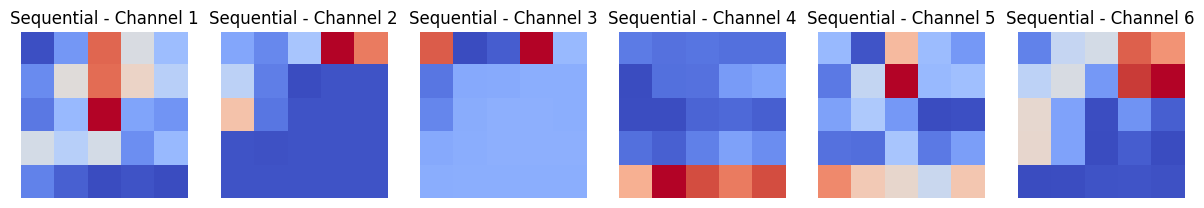

In [21]:
def visualize_activation(activation, title, num_channels=6):
    activation = activation.squeeze(0) 
    num_features = min(activation.size(0), num_channels)
    plt.figure(figsize=(15, 5))
    for i in range(num_features):
        plt.subplot(1, num_features, i + 1)
        plt.imshow(activation[i].detach().numpy(), cmap='coolwarm')
        plt.axis('off')
        plt.title(f"{title} - Channel {i + 1}")
    plt.show()

for name, activation in activations.items():
    if "block" not in name:
        break
    layer_type = layer_types[name]
    print(f"Visualizing: {layer_type}, shape: {activation.shape}")
    visualize_activation(activation, layer_type)